# Classificação de Carteira

Esse notebook objetiva analisar a carteira de clientes que cada vendedor atende e os resultados obtidos, classificando-os conforme sua performance em notas de 1 a 5.

# Biblioteca + Dados

In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import sklearn
from unidecode import unidecode

In [256]:
df_raw = pd.read_excel(r"Dados - Vendas.xlsx")

In [257]:
df_meta_original = pd.read_excel(r"Metas - Vendedores.xlsx")

In [258]:
df_meta_original['MODELO DE RV'].unique()

array(['HUNTER', 'BASE'], dtype=object)

In [259]:
# Manter as linhas onde RV = 'BASE'
df_meta = df_meta_original[df_meta_original['MODELO DE RV'] == 'BASE'].reset_index(drop=True)

In [260]:
# Desformatar nome do vendedor
df_meta['VENDEDOR'] = df_meta['VENDEDOR'].astype(str)
df_meta['VENDEDOR'] = df_meta['VENDEDOR'].apply(lambda x: ''.join(caractere for caractere in x if not caractere.isdigit()))

df_meta['VENDEDOR'] = df_meta['VENDEDOR'].str.lower()
df_meta['VENDEDOR'] = df_meta['VENDEDOR'].str.replace('-', ' ')
df_meta['VENDEDOR'] = df_meta['VENDEDOR'].apply(unidecode)

In [261]:
df_meta

,LOJA,VENDEDOR,NÍVEL,CARGO,MODELO DE RV,2024-01-01 00:00:00,2024-02-01 00:00:00,2024-03-01 00:00:00
0,LOJA 1,vendedor f,II,BASE II,BASE,1349092,883966,730175
1,LOJA 2,vendedor b,I,BASE I,BASE,1576223,1069209,1554963
2,LOJA 2,vendedor c,III,BASE III,BASE,1265055,1045829,939132
3,LOJA 2,vendedor d,I,BASE I,BASE,890927,1535909,1376390
4,LOJA 2,vendedor e,II,BASE II,BASE,892380,949718,1505237
5,LOJA 1,vendedor g,II,BASE II,BASE,752285,1414524,703068
6,LOJA 2,vendedor i,III,BASE III,BASE,1454098,1346982,1034753
7,LOJA 2,vendedor j,II,BASE II,BASE,1424601,1547535,682584


In [262]:
# Selecionar colunas de datas para agrupar
colunas_datas = df_meta.columns[6:]

# Utilizar a função melt para agrupar as colunas de datas em uma única coluna de data
df_melted = pd.melt(df_meta, id_vars=['LOJA', 'VENDEDOR', 'CARGO', 'NÍVEL', 'MODELO DE RV'],
                    value_vars=colunas_datas, var_name='DATA_VENDA', value_name='META VENDEDOR')

# Converter a coluna 'Data' para o formato datetime, se necessário
df_melted['DATA_VENDA'] = pd.to_datetime(df_melted['DATA_VENDA'])

In [263]:
# Converter a coluna 'Data' para objetos datetime
df_melted['DATA_VENDA'] = pd.to_datetime(df_melted['DATA_VENDA'])

# Extrair trimestres e criar uma nova coluna com o Q correspondente
df_melted['TRIMESTRE'] = df_melted['DATA_VENDA'].dt.to_period("Q")

In [264]:
# Desformatar nome do vendedor
df_raw['VENDEDOR'] = df_raw['VENDEDOR'].astype(str)
df_raw['VENDEDOR'] = df_raw['VENDEDOR'].apply(lambda x: ''.join(caractere for caractere in x if not caractere.isdigit()))

df_raw['VENDEDOR'] = df_raw['VENDEDOR'].str.lower()
df_raw['VENDEDOR'] = df_raw['VENDEDOR'].str.replace('-', ' ')
df_raw['VENDEDOR'] = df_raw['VENDEDOR'].apply(unidecode)

In [265]:
# Converter a coluna 'Data' para objetos datetime
df_raw['DATA'] = pd.to_datetime(df_raw['DATA'])

# Extrair trimestres e criar uma nova coluna com o Q correspondente
df_raw['TRIMESTRE'] = df_raw['DATA'].dt.to_period("Q")

In [266]:
df_melted.columns

Index(['LOJA', 'VENDEDOR', 'CARGO', 'NÍVEL', 'MODELO DE RV', 'DATA_VENDA',
       'META VENDEDOR', 'TRIMESTRE'],
      dtype='object')

In [267]:
# Agrupar pelo 'Cargo', 'Nível', 'Nome Do Ear Da Venda' e 'Trimestre' e calcular métricas
df_meta_final = df_melted.groupby(['VENDEDOR', 'TRIMESTRE']).agg(
    Nome_Loja=('LOJA', 'first'),
    Cargo=('CARGO', 'first'),
    Nivel=('NÍVEL', 'first'),
    META_VENDEDOR=('META VENDEDOR', 'sum')
).reset_index()

# Criação de indicadores

In [268]:
df_raw['DELTA POTENCIAL'] = df_raw['POTENCIAL DO CLIENTE'] - df_raw['RECEITA MENSAL']-df_raw['PRODUÇÃO DE VENDAS']

In [269]:
df_raw['DELTA POTENCIAL'] = df_raw['DELTA POTENCIAL'].apply(lambda x: max(0, x))

In [270]:
# Dividir a coluna de valores
df_raw['CLASSIF_QUARTIL'] = pd.qcut(df_raw['DELTA POTENCIAL'], q=9, labels=False, duplicates='drop')

In [271]:
# Normalizar entre 5 e 1
min_val = df_raw['DELTA POTENCIAL'].min()
max_val = df_raw['DELTA POTENCIAL'].max()


df_raw['CLASSIF_NORMALIZADA'] = df_raw['DELTA POTENCIAL'].apply(
    lambda x: 1 + ((x - min_val) * (5 - 1)) / (max_val - min_val)
    )

In [272]:
df_raw.columns

Index(['LOJA', 'VENDEDOR', 'DATA', 'CLIENTE', 'PRODUÇÃO DE VENDAS',
       'RECEITA MENSAL', 'POTENCIAL DO CLIENTE', 'TRIMESTRE',
       'DELTA POTENCIAL', 'CLASSIF_QUARTIL', 'CLASSIF_NORMALIZADA'],
      dtype='object')

In [273]:
# Definir as funções de agregação
def terceiro_quartil(series):
    return series.quantile(0.75)

# Agrupar pelo 'Cargo', 'Nível', 'Vendedor', 'Trimestre' e calcular métricas
df_tratado = df_raw.groupby(['VENDEDOR', 'TRIMESTRE']).agg(
    CLASSIF_QUARTIL_MEAN=('CLASSIF_QUARTIL', 'mean'),
    CLASSIF_QUARTIL_3O_QUARTIL=('CLASSIF_QUARTIL', terceiro_quartil),
    CLASSIF_QUARTIL_STD=('CLASSIF_QUARTIL', 'std'),
    CLASSIF_NORMALIZADA_MEAN=('CLASSIF_NORMALIZADA', 'mean'),
    CLIENTE_COUNT=('CLIENTE', 'nunique'),
    PRODUCAO_SUM=('PRODUÇÃO DE VENDAS', 'sum')
).reset_index()

In [274]:
# Merge usando a coluna de ID e trimestre
df_merge = pd.merge(df_meta_final, df_tratado, left_on=['VENDEDOR', 'TRIMESTRE'], right_on=['VENDEDOR', 'TRIMESTRE'], how='left')

In [ ]:
# Adicionando o atingimento de meta
df_merge['ATG_META'] = df_merge['PRODUCAO_SUM']/df_merge['META_VENDEDOR']

In [278]:
df_merge.describe()

,META_VENDEDOR,CLASSIF_QUARTIL_MEAN,CLASSIF_QUARTIL_3O_QUARTIL,CLASSIF_QUARTIL_STD,CLASSIF_NORMALIZADA_MEAN,CLIENTE_COUNT,PRODUCAO_SUM,ATG_META
count,8.000000e+00,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000e+00,8.000000
mean,2.289997e+06,1.105544,2.000000,1.443656,1.392503,42.375000,2.127731e+06,0.997282
std,3.995885e+05,0.305436,0.755929,0.183818,0.138542,33.632202,1.376495e+06,0.860866
min,1.614141e+06,0.725000,1.000000,1.198022,1.239162,7.000000,1.026299e+06,0.440934
25%,2.084434e+06,0.857372,1.750000,1.343764,1.285086,20.500000,1.092863e+06,0.510231
50%,2.305927e+06,1.062500,2.000000,1.391668,1.356246,33.500000,1.573474e+06,0.658048
75%,2.497259e+06,1.302062,2.250000,1.533193,1.471028,58.250000,2.748058e+06,0.996036
max,2.912299e+06,1.562500,3.000000,1.744802,1.650411,108.000000,4.841484e+06,2.999418


In [280]:
df_merge

,VENDEDOR,TRIMESTRE,Nome_Loja,Cargo,Nivel,META_VENDEDOR,CLASSIF_QUARTIL_MEAN,CLASSIF_QUARTIL_3O_QUARTIL,CLASSIF_QUARTIL_STD,CLASSIF_NORMALIZADA_MEAN,CLIENTE_COUNT,PRODUCAO_SUM,ATG_META
0,vendedor b,2024Q1,LOJA 2,BASE I,I,2624172,1.482759,3.0,1.744802,1.650411,10,1990061,0.758358
1,vendedor c,2024Q1,LOJA 2,BASE III,III,1984961,1.562500,3.0,1.672075,1.510467,7,1107088,0.557738
2,vendedor d,2024Q1,LOJA 2,BASE I,I,2912299,1.125000,2.0,1.396321,1.368707,55,2571196,0.882875
3,vendedor e,2024Q1,LOJA 2,BASE II,II,2454955,1.000000,2.0,1.387015,1.343785,68,3278643,1.335521
4,vendedor f,2024Q1,LOJA 1,BASE II,II,1614141,1.241830,2.0,1.486900,1.457882,108,4841484,2.999418
5,vendedor g,2024Q1,LOJA 1,BASE II,II,2117592,0.861111,2.0,1.355471,1.284243,24,1026299,0.484654
6,vendedor i,2024Q1,LOJA 2,BASE III,III,2381735,0.846154,1.0,1.308645,1.285367,33,1050187,0.440934
7,vendedor j,2024Q1,LOJA 2,BASE II,II,2230119,0.725000,1.0,1.198022,1.239162,34,1156888,0.518756


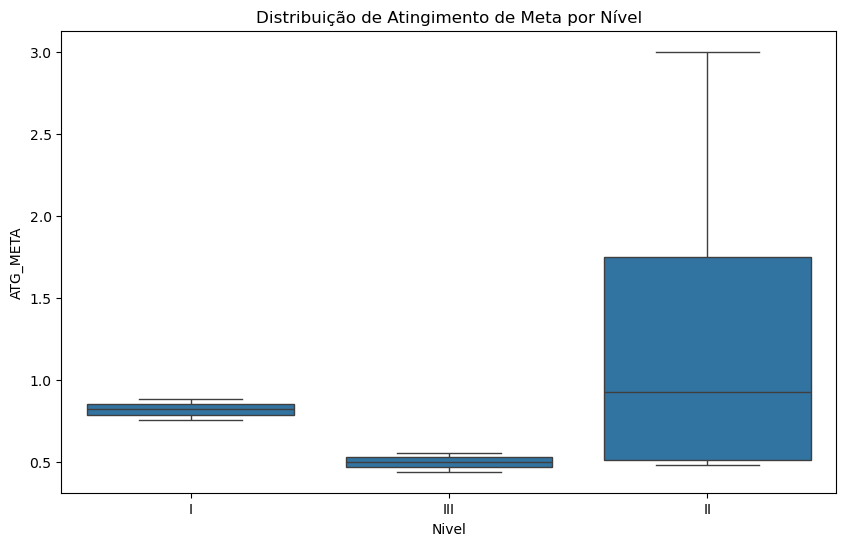

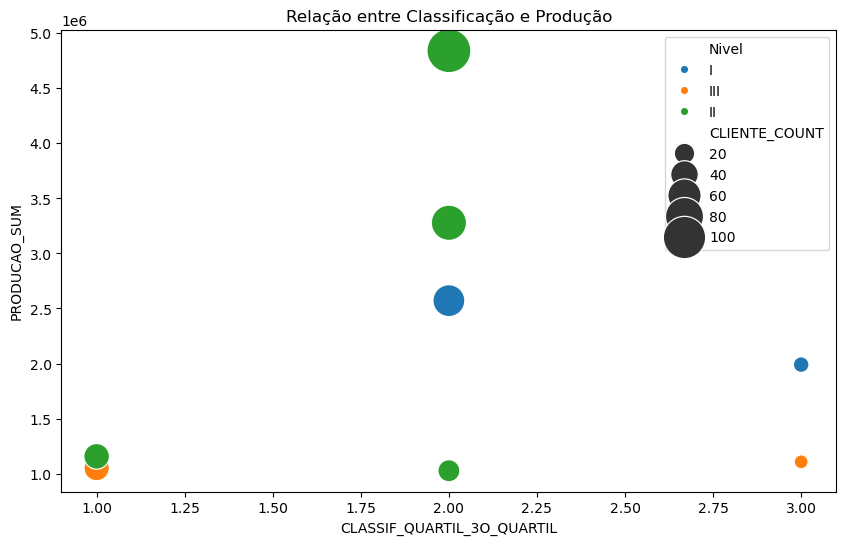

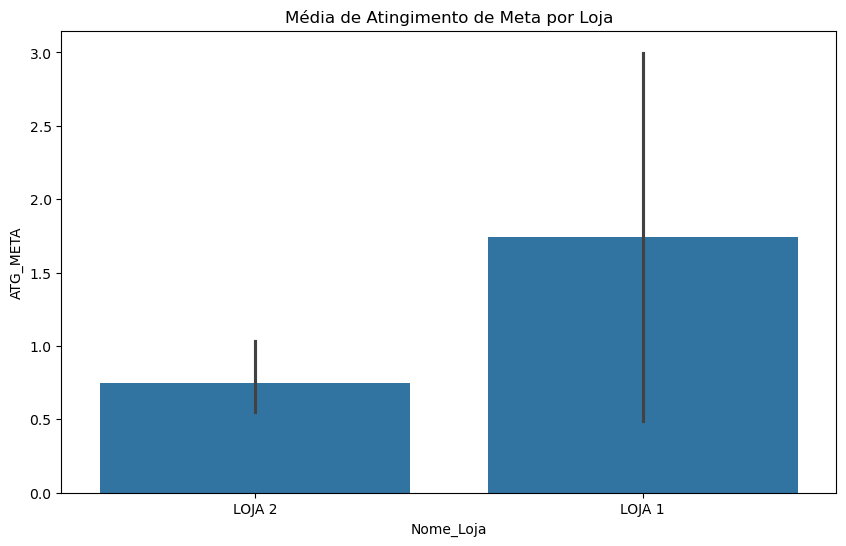

In [ ]:
# Performance por nível
plt.figure(figsize=(10, 6))
sns.boxplot(x='Nivel', y='ATG_META', data=df_merge)
plt.title('Distribuição de Atingimento de Meta por Nível')
plt.show()

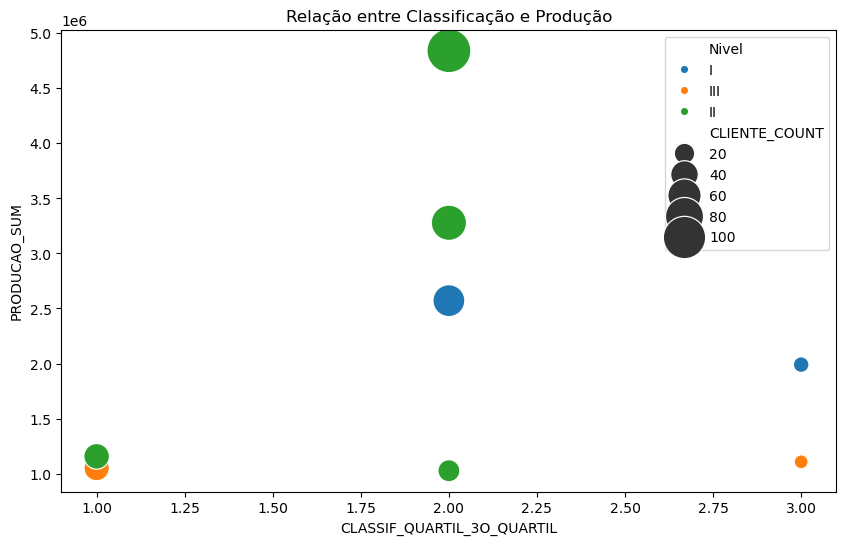

In [281]:
# Análise de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merge, x='CLASSIF_QUARTIL_3O_QUARTIL', y='PRODUCAO_SUM', 
                hue='Nivel', size='CLIENTE_COUNT', sizes=(100, 1000))
plt.title('Relação entre Classificação e Produção')
plt.show()

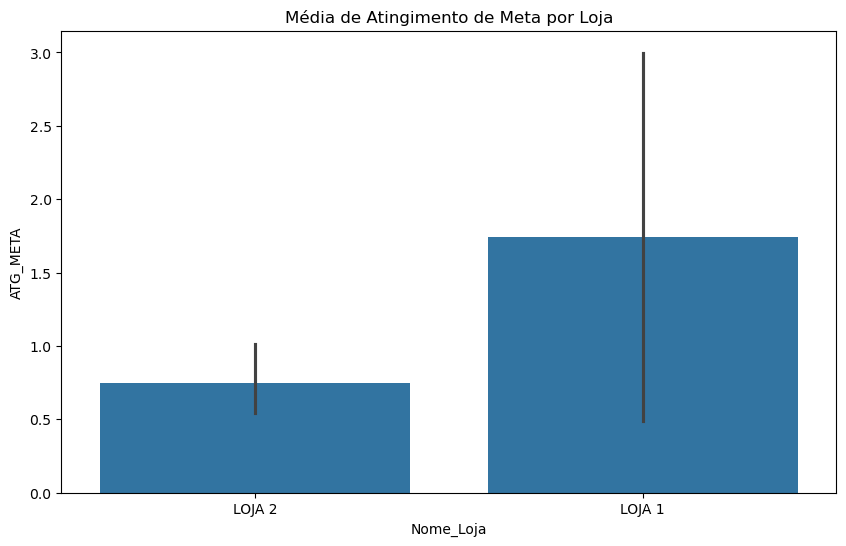

In [282]:
# Análise por loja
plt.figure(figsize=(10, 6))
sns.barplot(x='Nome_Loja', y='ATG_META', data=df_merge)
plt.title('Média de Atingimento de Meta por Loja')
plt.show()

#DOWNLOAD


In [ ]:
df_merge.to_excel(r'\df_merge.xlsx', index=False)